<a href="https://colab.research.google.com/github/yashk2000/LearningPyTorch/blob/main/Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions in action

In [1]:
 %matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

## Use GPU

In [2]:
torch.cuda.current_device()

0

In [3]:
torch.cuda.device(0)

In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Downloading the dataset 

In [5]:
from torchvision import datasets, transforms
data_path = './'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


Extracting ./cifar-10-python.tar.gz to ./


In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [8]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [9]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [13]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [14]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

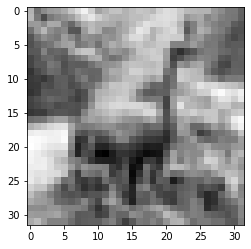

In [16]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

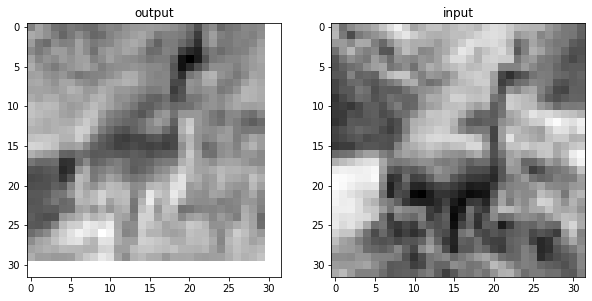

In [17]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

## Padding

In [18]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # <1>
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

## Detecting features with convolutions

In [19]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

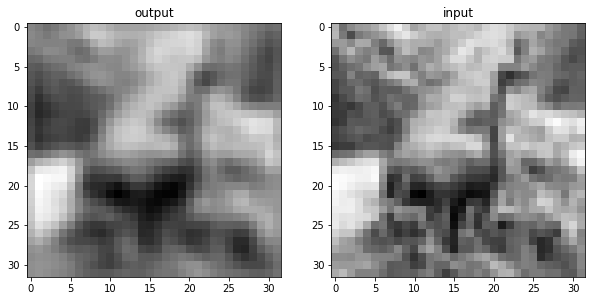

In [20]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [21]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

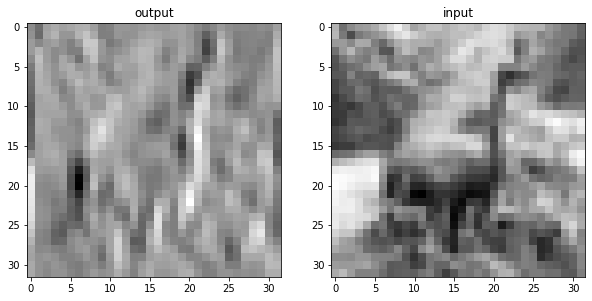

In [29]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

In [22]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [24]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1>
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
model(img.unsqueeze(0))

RuntimeError: ignored

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [29]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [30]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

In [31]:
import datetime 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader:  
            
            outputs = model(imgs)  
            
            loss = loss_fn(outputs, labels)  

            optimizer.zero_grad()  
            
            loss.backward()  
            
            optimizer.step() 

            loss_train += loss.item()  

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  

In [32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  # <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-03-13 13:15:11.654694 Epoch 1, Training loss 0.5633942809454195
2021-03-13 13:15:39.800743 Epoch 10, Training loss 0.32906689746364665
2021-03-13 13:16:11.644734 Epoch 20, Training loss 0.30338476313527224
2021-03-13 13:16:44.233957 Epoch 30, Training loss 0.28172748929755703
2021-03-13 13:17:15.868802 Epoch 40, Training loss 0.2641204426622695
2021-03-13 13:17:47.421434 Epoch 50, Training loss 0.24448542021642064
2021-03-13 13:18:18.907135 Epoch 60, Training loss 0.22565445142566778
2021-03-13 13:18:50.656965 Epoch 70, Training loss 0.20729724555068715
2021-03-13 13:19:22.673001 Epoch 80, Training loss 0.19094079239353254
2021-03-13 13:19:54.269745 Epoch 90, Training loss 0.17719464559274115
2021-03-13 13:20:25.941618 Epoch 100, Training loss 0.16293807693157986


In [33]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


In [34]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [35]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [36]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [37]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2021-03-13 13:22:31.460890 Epoch 1, Training loss 0.6044048091788201
2021-03-13 13:22:34.383520 Epoch 10, Training loss 0.3362160675275098
2021-03-13 13:22:37.707060 Epoch 20, Training loss 0.2979576348499128
2021-03-13 13:22:40.910515 Epoch 30, Training loss 0.27202304390964993
2021-03-13 13:22:44.212838 Epoch 40, Training loss 0.2525625332810317
2021-03-13 13:22:47.479313 Epoch 50, Training loss 0.23063038583773715
2021-03-13 13:22:50.810840 Epoch 60, Training loss 0.21475452400601594
2021-03-13 13:22:54.022634 Epoch 70, Training loss 0.20065623721119705
2021-03-13 13:22:57.225886 Epoch 80, Training loss 0.18740398142557996
2021-03-13 13:23:00.334310 Epoch 90, Training loss 0.1727076967478178
2021-03-13 13:23:03.412489 Epoch 100, Training loss 0.16315295684869122


In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.88


## Increasing network width

In [40]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [41]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2021-03-13 13:29:32.742929 Epoch 1, Training loss 0.5342485065672807
2021-03-13 13:29:35.935807 Epoch 10, Training loss 0.3177866199213988
2021-03-13 13:29:39.538719 Epoch 20, Training loss 0.27636992874418853
2021-03-13 13:29:43.090287 Epoch 30, Training loss 0.24538463781214065
2021-03-13 13:29:46.625546 Epoch 40, Training loss 0.21639657675460644
2021-03-13 13:29:50.221378 Epoch 50, Training loss 0.18962605235872754
2021-03-13 13:29:53.843659 Epoch 60, Training loss 0.16606328667254205
2021-03-13 13:29:57.515080 Epoch 70, Training loss 0.14477180938716908
2021-03-13 13:30:01.064414 Epoch 80, Training loss 0.12463955690336835
2021-03-13 13:30:04.632640 Epoch 90, Training loss 0.10549598127888267
2021-03-13 13:30:08.162534 Epoch 100, Training loss 0.08779512584256897
Accuracy train: 0.96
Accuracy val: 0.89


{'train': 0.962, 'val': 0.8945}

In [42]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [43]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2021-03-13 13:31:33.611654 Epoch 1, Training loss 0.5404658843377593
2021-03-13 13:31:36.773123 Epoch 10, Training loss 0.31773302215299787
2021-03-13 13:31:40.377506 Epoch 20, Training loss 0.2734197216808416
2021-03-13 13:31:43.920289 Epoch 30, Training loss 0.2400998723734716
2021-03-13 13:31:47.466586 Epoch 40, Training loss 0.21218463693075118
2021-03-13 13:31:51.099293 Epoch 50, Training loss 0.18737584921964415
2021-03-13 13:31:54.652243 Epoch 60, Training loss 0.16417632242486735
2021-03-13 13:31:58.232096 Epoch 70, Training loss 0.14208298539564868
2021-03-13 13:32:01.798533 Epoch 80, Training loss 0.1211204489420174
2021-03-13 13:32:05.389336 Epoch 90, Training loss 0.10175605231575716
2021-03-13 13:32:08.922396 Epoch 100, Training loss 0.08420967060337022
Accuracy train: 0.95
Accuracy val: 0.89


## Adding l2 regularizatioon

In [44]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1>
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [45]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2021-03-13 13:32:22.360096 Epoch 1, Training loss 0.587676922227167
2021-03-13 13:32:26.613594 Epoch 10, Training loss 0.35777634942227865
2021-03-13 13:32:31.209911 Epoch 20, Training loss 0.3231944158958022
2021-03-13 13:32:35.819629 Epoch 30, Training loss 0.2974192837051525
2021-03-13 13:32:40.538040 Epoch 40, Training loss 0.27767672603297383
2021-03-13 13:32:44.883321 Epoch 50, Training loss 0.2624259691709166
2021-03-13 13:32:49.249473 Epoch 60, Training loss 0.24975162621136685
2021-03-13 13:32:53.644420 Epoch 70, Training loss 0.23808451348049625
2021-03-13 13:32:57.987624 Epoch 80, Training loss 0.22715926070691675
2021-03-13 13:33:02.406300 Epoch 90, Training loss 0.21725529380095232
2021-03-13 13:33:06.987398 Epoch 100, Training loss 0.2085922811251537
Accuracy train: 0.92
Accuracy val: 0.89


## Dropout

In [46]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2021-03-13 13:33:09.354795 Epoch 1, Training loss 0.5585163210987285
2021-03-13 13:33:12.806387 Epoch 10, Training loss 0.3775740093106677
2021-03-13 13:33:16.710188 Epoch 20, Training loss 0.3520445363346938
2021-03-13 13:33:20.631914 Epoch 30, Training loss 0.3341416321742307
2021-03-13 13:33:24.525704 Epoch 40, Training loss 0.31691942017549163
2021-03-13 13:33:28.468993 Epoch 50, Training loss 0.2986969579556945
2021-03-13 13:33:32.285107 Epoch 60, Training loss 0.28085137552516476
2021-03-13 13:33:36.155656 Epoch 70, Training loss 0.274242795007244
2021-03-13 13:33:39.888721 Epoch 80, Training loss 0.26102350006817254
2021-03-13 13:33:43.652318 Epoch 90, Training loss 0.2473917539901794
2021-03-13 13:33:47.414420 Epoch 100, Training loss 0.23807454963398586
Accuracy train: 0.90
Accuracy val: 0.88


## Batch Normalization

In [48]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [49]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2021-03-13 13:33:50.216073 Epoch 1, Training loss 0.49661661523162937
2021-03-13 13:33:54.106095 Epoch 10, Training loss 0.2746981905334315
2021-03-13 13:33:58.378195 Epoch 20, Training loss 0.21117056854021776
2021-03-13 13:34:02.823899 Epoch 30, Training loss 0.1652455170917663
2021-03-13 13:34:07.171149 Epoch 40, Training loss 0.12460561466824477
2021-03-13 13:34:11.338083 Epoch 50, Training loss 0.08765291009738946
2021-03-13 13:34:15.647349 Epoch 60, Training loss 0.05843308134965456
2021-03-13 13:34:19.837006 Epoch 70, Training loss 0.0374581631433195
2021-03-13 13:34:24.080521 Epoch 80, Training loss 0.060114711009938815
2021-03-13 13:34:28.384472 Epoch 90, Training loss 0.01632403965541132
2021-03-13 13:34:32.722163 Epoch 100, Training loss 0.01096580740491486
Accuracy train: 0.99
Accuracy val: 0.87


## Increasing Depth

In [50]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [51]:

model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)


2021-03-13 13:34:33.481843 Epoch 1, Training loss 0.6913352399874645
2021-03-13 13:34:37.214624 Epoch 10, Training loss 0.349676211548459
2021-03-13 13:34:41.347539 Epoch 20, Training loss 0.30573056078260874
2021-03-13 13:34:45.492027 Epoch 30, Training loss 0.27331795491230715
2021-03-13 13:34:49.528693 Epoch 40, Training loss 0.2406905363699433
2021-03-13 13:34:53.589422 Epoch 50, Training loss 0.20808514582503373
2021-03-13 13:34:57.634906 Epoch 60, Training loss 0.17697681719140643
2021-03-13 13:35:01.848384 Epoch 70, Training loss 0.14633967929110406
2021-03-13 13:35:05.779967 Epoch 80, Training loss 0.11834144504491691
2021-03-13 13:35:09.726808 Epoch 90, Training loss 0.09280733218428436
2021-03-13 13:35:13.742679 Epoch 100, Training loss 0.07002561900076593
Accuracy train: 0.97
Accuracy val: 0.90


## ResNet

In [52]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [53]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)


2021-03-13 13:35:57.046818 Epoch 1, Training loss 0.6443441206482565
2021-03-13 13:36:00.617714 Epoch 10, Training loss 0.33441638671288826
2021-03-13 13:36:04.741045 Epoch 20, Training loss 0.28773495146803035
2021-03-13 13:36:08.911777 Epoch 30, Training loss 0.2551462871443694
2021-03-13 13:36:13.016096 Epoch 40, Training loss 0.22765201054940556
2021-03-13 13:36:17.148731 Epoch 50, Training loss 0.20238398542259908
2021-03-13 13:36:21.276691 Epoch 60, Training loss 0.17834042624872962
2021-03-13 13:36:25.320380 Epoch 70, Training loss 0.15568789194343954
2021-03-13 13:36:29.388260 Epoch 80, Training loss 0.1336623836712093
2021-03-13 13:36:33.421313 Epoch 90, Training loss 0.11268339802030546
2021-03-13 13:36:37.378458 Epoch 100, Training loss 0.09051604928436932
Accuracy train: 0.95
Accuracy val: 0.90


## DeepRes

In [54]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [55]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [56]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2021-03-13 13:37:12.117571 Epoch 1, Training loss 2.2815751308088847
2021-03-13 13:38:33.886311 Epoch 10, Training loss 0.3353065527548456
2021-03-13 13:40:04.588532 Epoch 20, Training loss 0.2608163610670217
2021-03-13 13:41:35.407108 Epoch 30, Training loss 0.204783715022977
2021-03-13 13:43:06.411050 Epoch 40, Training loss 0.15619128562842205
2021-03-13 13:44:37.229881 Epoch 50, Training loss 0.11403051599160216
2021-03-13 13:46:07.842614 Epoch 60, Training loss 0.1080228418918552
2021-03-13 13:47:38.690914 Epoch 70, Training loss 0.07693886280854702
2021-03-13 13:49:09.171401 Epoch 80, Training loss 0.047872875782269626
2021-03-13 13:50:39.915543 Epoch 90, Training loss 0.0809959336969954
2021-03-13 13:52:10.680314 Epoch 100, Training loss 0.055207581736835515
Accuracy train: 0.96
Accuracy val: 0.86


## Comparing all results

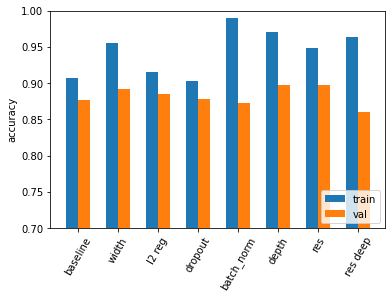

In [57]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()